# 🐸캐굴캐굴 필사 스터디 3주차
3주차 학습 기간 : 23.02.13 ~ 23.02.19    
주제 : House Prices - Advanced Regression Techniques  
- 판매 가격 예측 및 feature 엔지니어링, RF 및 그레이디언트 부스팅 실습
    - Lasso 회귀 모델
    - XGBoost 모델
    - LGBM 모델 
- plotly 사용자 정의 시각화 및 EDA 
- 아이오와주 에임스에 있는 주거용 주택의 (거의) 모든 측면을 설명하는 79개
의 독립 변수로 각 주택의 최종 가격을 예측
    
<br>



### ✅알게 된 내용

- 머신러닝을 이용한 회귀 모델 학습 프로세스 복습
- Box-Cox 변환법 
- One-Hot Encoder 와 get_dummies의 차이

## 📋 필사한 노트북
## [#1 House Prices Solution [top 1%]](https://www.kaggle.com/code/jesucristo/1-house-prices-solution-top-1)
  
+) 0701 ~ 0702 멋사AIS7 실습파일

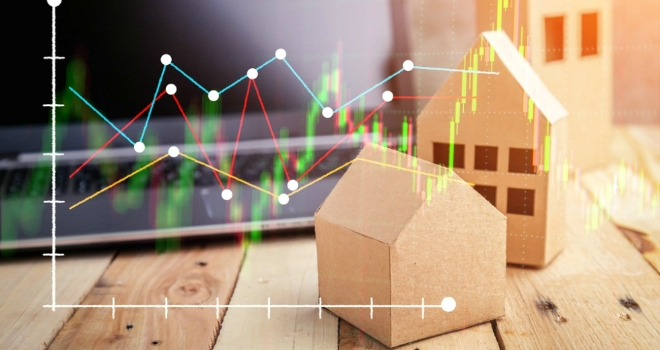



#### 📌DATASET 설명

There are 1460 instances of training data and 1460 of test data. Total number of attributes equals 81, of which 36 is quantitative, 43 categorical + Id and SalePrice.
- 학습 데이터 1460개 + 테스트 데이터 1460개
- 36개의 수치형 변수와 43개의 범주형 변수 (총 81개)
- Target 값은 주택 판매 가격


## Load Package

In [110]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from datetime import datetime

from scipy.stats import skew  # for some statistics
from scipy.stats import boxcox
from scipy.special import boxcox1p # Box-cox 변환법 
from scipy.stats import boxcox_normmax

from sklearn.ensemble import RandomForestRegressor
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
import sklearn.linear_model as linear_model
from sklearn.svm import SVR

# StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

from sklearn.pipeline import make_pipeline
import scipy.stats as stats
from sklearn.model_selection import cross_val_predict

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, cross_val_score

from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV

from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

import os
print(os.listdir("/content/drive/MyDrive/캐굴캐굴/3주차"))

import warnings
warnings.filterwarnings('ignore')

base_root =f'/content/drive/MyDrive/캐굴캐굴/3주차'

['dataset', '0701-house-prices-feature_engineering-output.ipynb', '0702-house-feature_engineering-predict-output.ipynb', '#1 House Prices Solution [top 1%]_완전필사.ipynb', '#1 House Prices Solution [top 1%]_학습한_내용.ipynb']


## load Data

In [111]:
train = pd.read_csv(f'{base_root}/dataset/train.csv')
test = pd.read_csv(f'{base_root}/dataset/test.csv')
print ("Data is loaded!")

Data is loaded!


### Data info 확인

In [112]:
pd.set_option('display.max_columns', None)
plt.style.use("ggplot")

In [113]:
train.shape, test.shape

((1460, 81), (1459, 80))

In [118]:
# label 정답
set(train.columns) - set(test.columns)

{'SalePrice'}

- Label값은 SalePrice인 것을 알 수 있다. 

In [119]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [120]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

#### 📌 Data Type
##### **Quantitative**
1stFlrSF, 2ndFlrSF, 3SsnPorch, BedroomAbvGr, BsmtFinSF1, BsmtFinSF2, BsmtFullBath, BsmtHalfBath, BsmtUnfSF, EnclosedPorch, Fireplaces, FullBath, GarageArea, GarageCars, GarageYrBlt, GrLivArea, HalfBath, KitchenAbvGr, LotArea, LotFrontage, LowQualFinSF, MSSubClass, MasVnrArea, MiscVal, MoSold, OpenPorchSF, OverallCond, OverallQual, PoolArea, ScreenPorch, TotRmsAbvGrd, TotalBsmtSF, WoodDeckSF, YearBuilt, YearRemodAdd, YrSold

##### **Qualitative**
Alley, BldgType, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, BsmtQual, CentralAir, Condition1, Condition2, Electrical, ExterCond, ExterQual, Exterior1st, Exterior2nd, Fence, FireplaceQu, Foundation, Functional, GarageCond, GarageFinish, GarageQual, GarageType, Heating, HeatingQC, HouseStyle, KitchenQual, LandContour, LandSlope, LotConfig, LotShape, MSZoning, MasVnrType, MiscFeature, Neighborhood, PavedDrive, PoolQC, RoofMatl, RoofStyle, SaleCondition, SaleType, Street, Utilities,

In [121]:
quantitative = [f for f in train.columns if train.dtypes[f] != 'object']
quantitative.remove('SalePrice')
quantitative.remove('Id')

In [122]:
qualitative = [f for f in train.columns if train.dtypes[f] == 'object']

In [123]:
quantitative

['MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold']

In [124]:
qualitative

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

### Descriptive statistics
- 결측치가 있는지
- 이상치가 있는지
- 표준편차는 어떤지
- 전체 피처에 대한 특이점 파악 
- 0~3 범위처럼 수치범위가 개수가 적다면 범주형데이터에 더 가깝다.
    - ```nunique()``` 값으로 추가 확인 필요

In [125]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


#### 히스토그램으로 데이터 분포 확인하기
- 수치 데이터의 분포 확인, 
    - 첨도를 살핀다.
        - 너무 뾰족하지 않은가? 한쪽에 데이터가 몰려있는지 확인한다.
    - 왜도를 살핀다.
        - 너무 한쪽에 치우쳐져 있지 않은지 확인한다. 
- 정규분포 형태인지 확인한다.
- 막대가 떨어져 있다면 수치 데이터가 아니라 범주형 데이터가 아닌지 확인할 수 있다.
    - 전처리를 한다면 학습과 예측에 도움이 될만한 피처엔지니어링 기법이 무엇이 있을지 고민해야한다. 


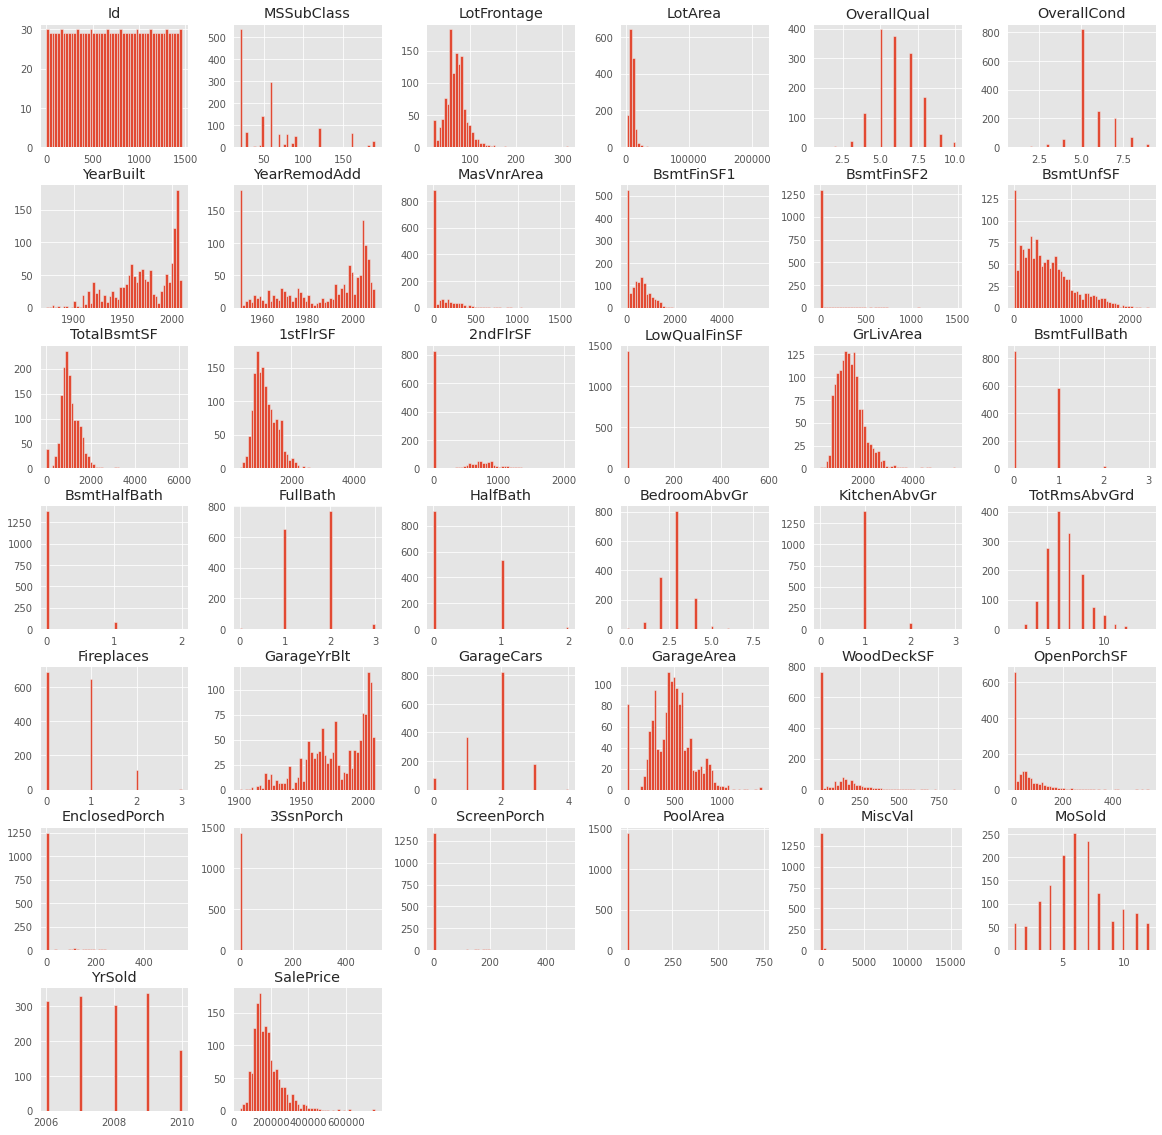

In [126]:
train.hist(figsize=(20, 20), bins=50);

### Missing Data 살펴보기

#### 결측치 개수

In [127]:
missing = train.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
missing

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64

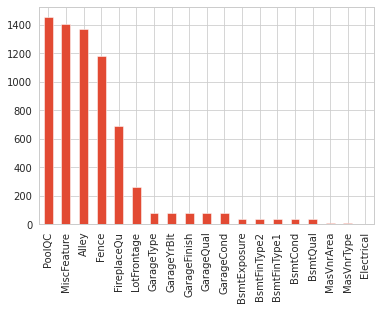

In [128]:
sns.set_style("whitegrid")

missing.plot.bar()

#### 결측치 비율

Train Data 

In [129]:
missing_mean = train.isnull().mean() * 100

pd.concat([missing, missing_mean], axis=1).loc[missing.index]

,0,1
PoolQC,1453.0,99.520548
MiscFeature,1406.0,96.301370
Alley,1369.0,93.767123
Fence,1179.0,80.753425
FireplaceQu,690.0,47.260274
LotFrontage,259.0,17.739726
GarageType,81.0,5.547945
GarageYrBlt,81.0,5.547945
GarageFinish,81.0,5.547945
GarageQual,81.0,5.547945


Test Data

In [130]:
test_null = test.isnull().sum()
test_na_sum = test_null[test_null > 0].sort_values(ascending=False)

test_na_mean = test.isnull().mean() * 100

pd.concat([test_na_sum, test_na_mean], axis=1).loc[test_na_sum.index]

,0,1
PoolQC,1456.0,99.794380
MiscFeature,1408.0,96.504455
Alley,1352.0,92.666210
Fence,1169.0,80.123372
FireplaceQu,730.0,50.034270
LotFrontage,227.0,15.558602
GarageCond,78.0,5.346127
GarageYrBlt,78.0,5.346127
GarageQual,78.0,5.346127
GarageFinish,78.0,5.346127


### 이상치 탐색

이상치가 있을 경우의 처리 방법 
- 이상치를 평균이나 중앙값 등으로 대체하면 데이터 왜곡이 발생할 수 있다.
    - 적절한 처리 방법을 깊게 고민해봐야 한다.
- 현실세계에서 풀어야할 문제 중에는 이상치를 탐지하는 문제도 있다는 것.

In [131]:
# SalePrice
train["SalePrice"].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

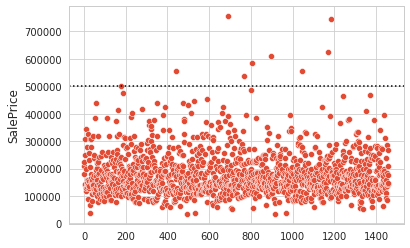

In [132]:
sns.scatterplot(data=train, x=train.index, y="SalePrice")
plt.axhline(500000, c="k", ls=":")

### 희소값 탐색
- 범주형 변수의 개수가 많은 것 중에서 빈도가 균일한지 아닌지 판단
    - nunique()을 통해 범주가 많은게 어떤 변수인지 확인한다. 

```nlargest()```
- ```df.sort_values(cols, ascending=False).head(n)``` 과 동일한 기능을 하는 아주 효율적인 메서드 

In [133]:
train.select_dtypes(include="object").nunique().nlargest(10)

Neighborhood    25
Exterior2nd     16
Exterior1st     15
Condition1       9
SaleType         9
Condition2       8
HouseStyle       8
RoofMatl         8
Functional       7
RoofStyle        6
dtype: int64

범주형 데이터 중에서 빈도가 적게 등장하는 값
- one-hot-encoding 을 했을 때 범주가 적은 값을 피처로 만들어 주면 연산에 시간이 더 오래걸릴 수도 있고 오버피팅(과대적합)이 일어날 수 있다.
- 너무 희소값이라면 기타로 묶는 방법도 있고 아예 결측치로 처리하고 pd.get_dummies 혹은 OneHotEncoder를 사용했을 때 인코딩 하지 않는다.


In [134]:
# Neighborhood - value_counts
ncount = train["Neighborhood"].value_counts()
ncount

NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
StoneBr     25
SWISU       25
MeadowV     17
Blmngtn     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: Neighborhood, dtype: int64

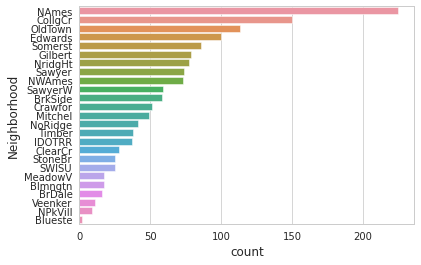

In [135]:
sns.countplot(data=train, y="Neighborhood", order=ncount.index)

- 희소한 값을 사용하고자 한다면     
1) 아예 희소값을 결측치 처리하면 one-hot-encoding 하지 않는다.    
2) 희소한 값을 "기타" 등으로 묶어줄 수도 있다.    

## Feature Scaling & Transformation

- Standard Scaler
    - 평균이 0, 표준편차가 1입니다.
    - Z-score scaling    
```z = (X - X.mean) / std```

- MinMax Scaler
    - 최소값이 0, 최대값이 1입니다
```X_scaled = (X - X.min) / (X.max - X.min)```

- Robust Scaler
    - **IQR**을 기준으로 scaling 하기 때문에 Standard Scaler보다 더 큰 최소값, 더 작은 최대값을 갖는다. 
```X_scaled = (X - X.median) / IQR```

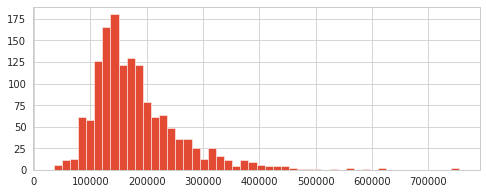

In [136]:
# SalePrice
train["SalePrice"].hist(bins=50, figsize=(8, 3));

### Standard Scaler
-  ```fit()``` 은 데이터를 기준으로 평균, 중앙값, 표준편차 기술통계값을 구한 뒤, 결과 값을 기준으로 transform 에서 계산을 적용한다. 
```
z = (x - u) / s
z = (X - X.mean) / std
```
- StandardScaler의 fit 에는 matrix가 들어간다.
    - Series가 아닌 DataFrame 으로 넣어주기 위해 대괄호를 두번 감싸서 데이터프레임으로 넣어주어야 한다. 
- 반환값 또한 matrix 형태이기 때문에 새로운 파생변수를 만들고자 한다면 데이터프레임 형태로 파생변수를 만들어야 한다. 
- train dataset 전처리 과정에서는 fit => transform을 사용
    - fit 은 train 에만 사용하고 transform 은 train, test 에 사용
    - fit 은 test 에 사용하지 않습니다.
        - why ? 기준을 train으로 정하기 위해
    - test 에는 train을 기준으로 학습한 것을 바탕으로 transform 만 적용



In [137]:
ss = StandardScaler()
ss

StandardScaler()

In [138]:
train[["SalePrice_ss"]] = ss.fit(train[["SalePrice"]]).transform(train[["SalePrice"]])
train[["SalePrice", "SalePrice_ss"]].head(2)

,SalePrice,SalePrice_ss
0,208500,0.347273
1,181500,0.007288


### MinMax Scaler 
- 주의 : 피처에 fit_transform 은 train 에만 사용할 것
    - test 에는 transform만 적용 
- test 에도 fit을 하게 되면 train, test 의 기준이 달라짐

In [139]:
mm = MinMaxScaler()
train[["SalePrice_mm"]] = mm.fit_transform(train[["SalePrice"]])

### Robust Scaler 


In [140]:
rs = RobustScaler()
train[["SalePrice_rs"]] = rs.fit_transform(train[["SalePrice"]])

In [141]:
train[["SalePrice", "SalePrice_ss", "SalePrice_mm", "SalePrice_rs"]].describe().round(2)

,SalePrice,SalePrice_ss,SalePrice_mm,SalePrice_rs
count,1460.0,1460.00,1460.00,1460.00
mean,180921.2,0.00,0.20,0.21
std,79442.5,1.00,0.11,0.95
min,34900.0,-1.84,0.00,-1.52
25%,129975.0,-0.64,0.13,-0.39
50%,163000.0,-0.23,0.18,0.00
75%,214000.0,0.42,0.25,0.61
max,755000.0,7.23,1.00,7.05


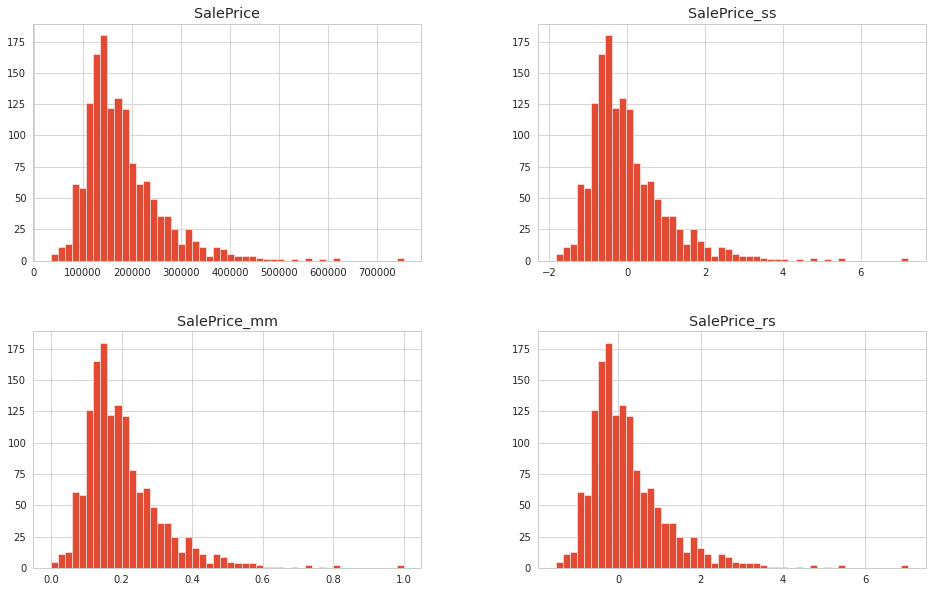

In [142]:
train[["SalePrice", "SalePrice_ss", "SalePrice_mm", "SalePrice_rs"]].hist(bins=50, figsize=(16, 10));

- x 축의 값은 다 다르지만 분포는 동일

### BoxCox Transformation

- 분포의 Skew를 조절하는 함수 변환법
- 정규분포가 아닌 자료를 정규분포로 바꾸기 위해 사용
- lambda 값을 조절하면서 분포가 정규분포가 되는 최적의 lambda 값 탐색
    - 임의의 분포를 어떻게 정규분포에 가깝게 변환할 수 있을 것인가?가 주 과제
    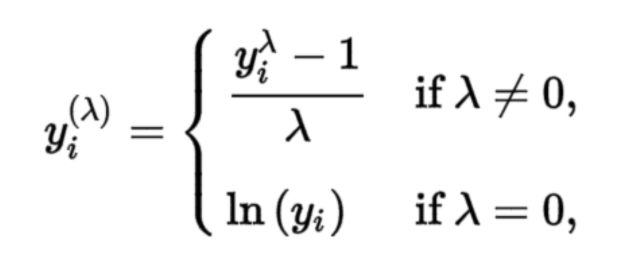
        - 람다가 0일때와 람다가 0이 아닐 때로 구분 되어 있음
        - 데이터 y에 대해서 람다가 하나 주어지면 하나의 함수변환이 되는 것
            ```
            람다(λ) = +2 : 이차함수

            람다(λ) = +0.5 : 루트 변환

            람다(λ) = +0 : 로그 변환

            람다(λ) = -1 : 역수 변환
            ```
- 지수,로그,루트,역수 변환 등 데이터의 함수변환을 포괄하는 개념으로 적절한 변환으로 정규분포에 가깝도록 만드는 분포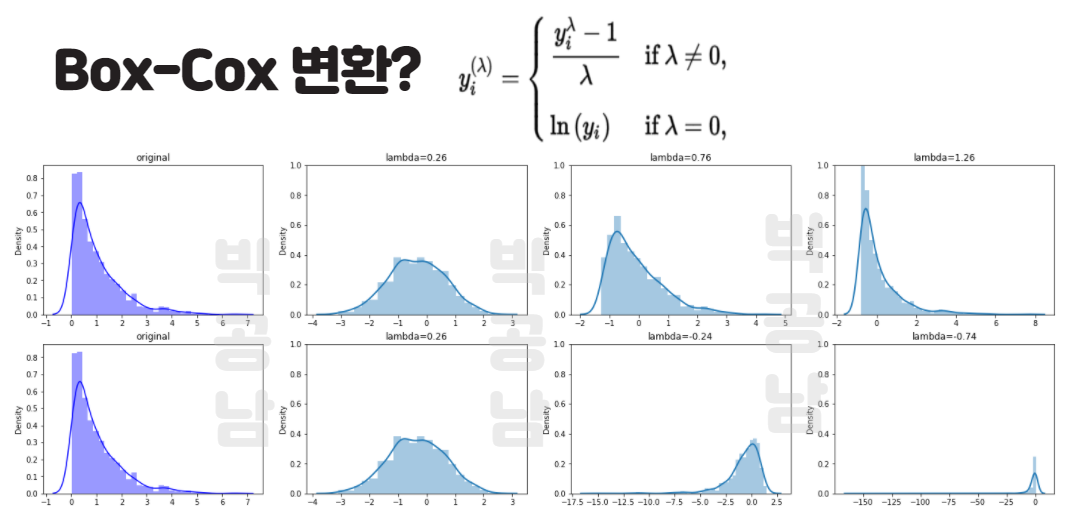
https://seeyapangpang.tistory.com/35
- 람다가 Opitmal Lambda는 0.26이 되고 좌우 대칭
- Lambda를 0.26 ☞ 0.76 ☞ 1.26 으로 숫자가 커지면, 점점 오른쪽 꼬리가 긴 Positive Skew그래프가 된다.
- Lambda를 0.26 ☞ -0.24 ☞ -0.74 으로 숫자가 작아지면, 점점 왼쪽 꼬리가 긴 Negative Skew그래프가 된다.
 



 



#### scipy.stats.boxcox()
- 박스 콕스의 결과를 변환된 y와 optimal lambda로 동시에 가져옴
    - ```return y, lambda_optimal```

In [143]:
import numpy as np 
from scipy import stats
import seaborn as sns 
import matplotlib.pyplot as plt
# create some random data
# 넘파이의 random함수로 지수분포 exponential을 붙여 데이터 샘플(size=1000) 생성 
x = np.random.exponential(size=1000)

# y optimal box cox transform
# optimal lambda (similar zero)

y, lambda_optimal = stats.boxcox(x)
print(lambda_optimal)

0.2508861587946967


####  scipy.special.boxcox1p()
- lambda_select는 사용자가 임의의 값을 입력.
- x가 아닌 x-1을 넣을 수 있다.
    - 같은 조건의 x에 대해서 비교가 가능하다.  

In [144]:
from scipy.special import boxcox1p
lambda_select = 0.7

#  scipy.special.boxcox1p() 
y = boxcox1p(x-1,lambda_select)
print(lambda_select)

0.7


#### Box-Cox 변환 시각화 

In [145]:
from sklearn import preprocessing

train['SalePrice_bc'] = preprocessing.scale(boxcox(train["SalePrice"]+1)[0])
train['SalePrice_bc1p'] = preprocessing.scale(boxcox1p(train["SalePrice"], boxcox_normmax(train["SalePrice"]+1)))
# normmax
'''
Returns:
maxlogfloat or ndarray
The optimal transform parameter found. 
최적의 람다 값을 반환 
'''

'\nReturns:\nmaxlogfloat or ndarray\nThe optimal transform parameter found. \n최적의 람다 값을 반환 \n'

In [146]:
boxcox_normmax(train["SalePrice"]+1)

-0.054537901823886

In [147]:
boxcox_normmax(train["SalePrice"])

-0.05452977947563627

+1을 적용하고 안하고의 차이는 아직 잘 모르겠다 ... ! 

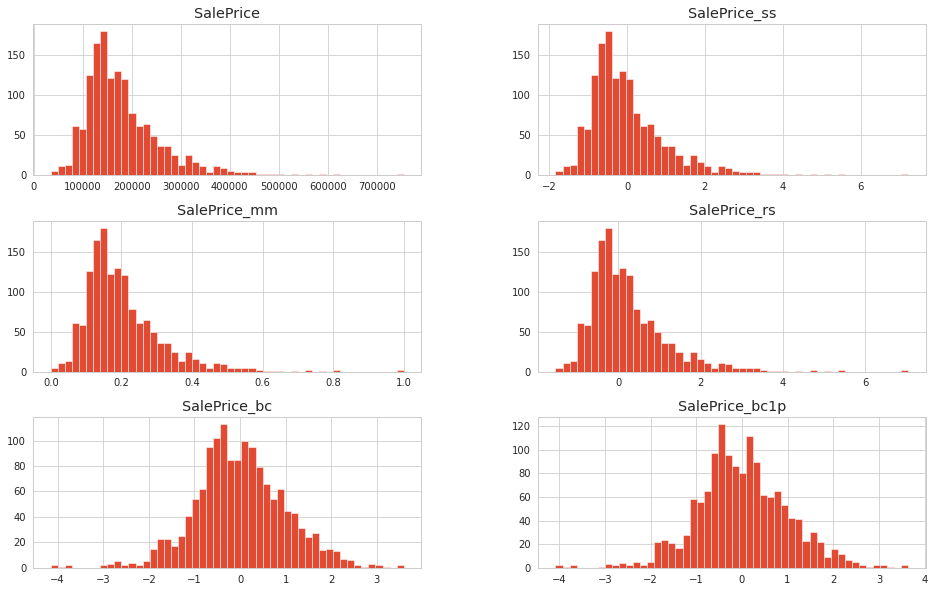

In [148]:
train[["SalePrice", "SalePrice_ss", "SalePrice_mm", "SalePrice_rs",'SalePrice_bc','SalePrice_bc1p']].hist(bins=50, figsize=(16, 10));

#### Box-Cox 활용 방법
- boxcox()에서 lambda에 따라 어떤 transform을 사용할 지 결정한다.
- 여러 변환을 수행할 수 있어 time series의 transform을 위한 강력한 도구로 사용할 수 있다
- https://gongjin-repository.tistory.com/17 

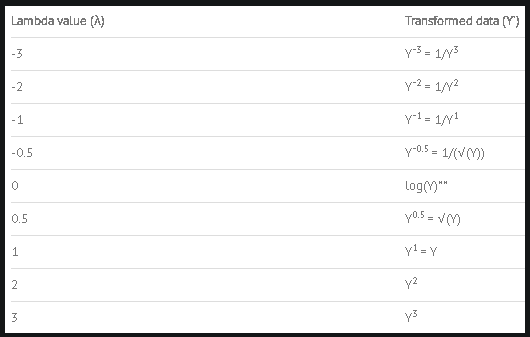
 

In [149]:
boxcox(train["SalePrice"])[1]

-0.07692391328663316

In [150]:
boxcox1p(train["SalePrice"], boxcox_normmax(train["SalePrice"]+1))

0       8.934125
1       8.862746
2       8.969679
3       8.727665
4       9.026741
          ...   
1455    8.843885
1456    8.937800
1457    9.059133
1458    8.735555
1459    8.754971
Name: SalePrice, Length: 1460, dtype: float64

- boxcox1p는 스케일링 결과까지 함께 출력해주는 것으로 보인다 

In [151]:
np.log1p(train["SalePrice"])

0       12.247694
1       12.109011
2       12.317167
3       11.849398
4       12.429216
          ...    
1455    12.072541
1456    12.254863
1457    12.493130
1458    11.864462
1459    11.901583
Name: SalePrice, Length: 1460, dtype: float64

### distplot() 확률분포 함수 시각화 
- seaborn 라이브러리의 distplot() 함수에서 fit 파라미터에 지정할 수 있는 확률분포 함수는 다음과 같다.
- scipy.stats 모듈에 정의된 확률분포 함수들이며, fit 파라미터에 함수명을 지정하면 해당 함수를 이용하여 데이터 분포와 가장 적합한 확률분포를 찾아서 시각화할 수 있다.    

<scipy.stats 모듈 함수 사용>
```
norm : 정규분포
gamma : 감마분포
expon : 지수분포
lognorm : 로그정규분포
beta : 베타분포
weibull : 와이블 분포
pareto : 파레토 분포
t : 스튜던트 t-분포
cauchy : 코시 분포
logistic : 로지스틱 분포
loglaplace : 로그라플라스 분포
johnsonsb : Johnson SB 분포
johnsonsu : Johnson SU 분포
```


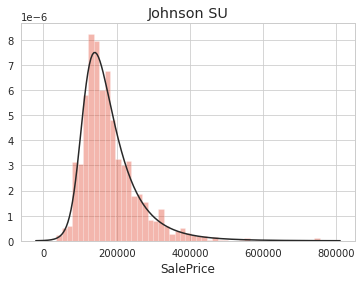

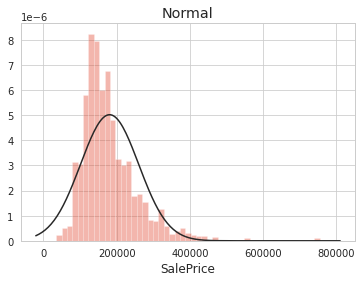

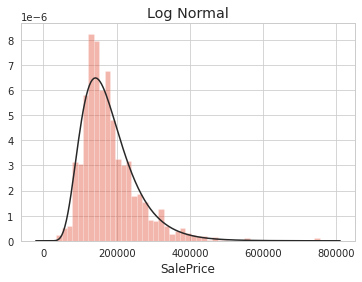

In [152]:
y = train['SalePrice']
plt.figure(1); plt.title('Johnson SU') 
# 밀도 곡선 (kde) 를 제외하고 출력 
sns.distplot(y, kde=False, fit=stats.johnsonsu) # 확률분포함수 적용 후 그래프 출력 

plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=stats.norm)

plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=stats.lognorm)

- SalePrice는 정규 분포를 따르지 않으므로 회귀 분석을 수행하기 전에 스케일링 해줘야한다. 

### Johnson SU 분포


- 파이썬의 scipy.stats 모듈에서 제공하는 확률 분포 함수 중 하나로 네 개의 모수로 정의되는 연속 확률 분포
-  확률 분포의 형태가 대체로 대칭적인 경우에 사용한다.
- 정규분포, 로지스틱 분포, 균등 분포 등 다양한 확률 분포를 모사할 수 있으며, 데이터의 대칭성을 모델링할 때 유용하다. 

## Feature Engineering

### 결측치 처리
- 결측치가 많다고 삭제하면 안된다.
- 이상치, 특잇값을 찾는다면 오히려 특정 값이 어떠한 인사이트가 될 수도 있다.
- 범주형 값이라면 결측치가 많더라도 채우지 않고 인코딩해주면 나머지 없는 값은 0으로 채워지게 된다. 
- 그 대신 희소한 행렬이 생성된다.
- 수치데이터인데 결측치라면 잘못채웠을 때 오해가 발생할 수 있으니 주의가 필요.

In [153]:
df = pd.concat([train, test])

isna_sum = df.isnull().sum()
isna_mean = df.isnull().mean()

null_feature = isna_mean[isna_mean > 0.8].index
df = df.drop(columns=null_feature)
df.shape

(2919, 82)

빠진 컬럼들 확인하기

In [154]:
set(test.columns) - set(df.columns)

{'Alley', 'Fence', 'MiscFeature', 'PoolQC'}

#### 결측치 채우기 
[Missingn Values 채우기](https://scikit-learn.org/stable/auto_examples/impute/plot_missing_values.html#sphx-glr-auto-examples-impute-plot-missing-values-py)

- 임의의 값으로 채우기
- 평균, 중앙값으로 채우기
- 제거하기
- 머신러닝 기법으로 채우기
- 0 또는 None 으로 채우기 

##### 수치형 변수 

In [155]:
# Garage 관련 수치형 변수 0 으로 결측치 대체
Garage_0 = ['GarageYrBlt', 'GarageArea', 'GarageCars']
print(df[Garage_0].isnull().sum())
df[Garage_0] = df[Garage_0].fillna(0)
print(df[Garage_0].isnull().sum())

GarageYrBlt    159
GarageArea       1
GarageCars       1
dtype: int64
GarageYrBlt    0
GarageArea     0
GarageCars     0
dtype: int64


In [156]:
# Garage 관련 범주형 변수 'None' 으로 결측치 대체
# 범주형 변수는 결측치를 채우지 않으면 따로 인코딩 하지 않습니다.
Garage_None = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
print(df[Garage_None].isnull().sum())
df[Garage_None] = df[Garage_None].fillna("None")

GarageType      157
GarageFinish    159
GarageQual      159
GarageCond      159
dtype: int64


In [157]:
df[Garage_None].isnull().sum()

GarageType      0
GarageFinish    0
GarageQual      0
GarageCond      0
dtype: int64

In [158]:
# Basement 관련 수치형 변수 0 으로 결측치 대체
Basement_0 = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 
              'BsmtFullBath', 'BsmtHalfBath']
print(df[Basement_0].isnull().sum())
df[Basement_0] = df[Basement_0].fillna(0)
print(df[Basement_0].isnull().sum())

BsmtFinSF1      1
BsmtFinSF2      1
BsmtUnfSF       1
TotalBsmtSF     1
BsmtFullBath    2
BsmtHalfBath    2
dtype: int64
BsmtFinSF1      0
BsmtFinSF2      0
BsmtUnfSF       0
TotalBsmtSF     0
BsmtFullBath    0
BsmtHalfBath    0
dtype: int64


In [159]:
# Basement 관련 범주형 변수 'None' 으로 결측치 대체
Basement_None = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
print(df[Basement_None].isnull().sum())
df[Basement_None] = df[Basement_None].fillna("None")
print(df[Basement_None].isnull().sum())

BsmtQual        81
BsmtCond        82
BsmtExposure    82
BsmtFinType1    79
BsmtFinType2    80
dtype: int64
BsmtQual        0
BsmtCond        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinType2    0
dtype: int64


##### 범주형 변수

In [160]:
# 범주형 변수는 결측치를 채우지 않으면 따로 인코딩 하지 않습니다.
# 없는 값도 의미를 부여하고자 할 때는 채울 수 있습니다.
fill_mode = ['MSZoning', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType', 'Functional']

# 가장 자주 출현한 값으로 (최빈값) 결측치를 채움 
df[fill_mode].mode().loc[0]

MSZoning            RL
KitchenQual         TA
Exterior1st    VinylSd
Exterior2nd    VinylSd
SaleType            WD
Functional         Typ
Name: 0, dtype: object

In [161]:
df[fill_mode].describe()

,MSZoning,KitchenQual,Exterior1st,Exterior2nd,SaleType,Functional
count,2915,2918,2918,2918,2918,2917
unique,5,4,15,16,9,7
top,RL,TA,VinylSd,VinylSd,WD,Typ
freq,2265,1492,1025,1014,2525,2717


In [162]:
df[fill_mode].describe().loc["top"]

MSZoning            RL
KitchenQual         TA
Exterior1st    VinylSd
Exterior2nd    VinylSd
SaleType            WD
Functional         Typ
Name: top, dtype: object

In [163]:
print('#----------결측치 채우기 전---------#')
print(df[fill_mode].isnull().sum())
df[fill_mode] = df[fill_mode].fillna(df[fill_mode].mode().loc[0])
print('#----------결측치 채운 후----------#')
print(df[fill_mode].isnull().sum())

#----------결측치 채우기 전---------#
MSZoning       4
KitchenQual    1
Exterior1st    1
Exterior2nd    1
SaleType       1
Functional     2
dtype: int64
#----------결측치 채운 후----------#
MSZoning       0
KitchenQual    0
Exterior1st    0
Exterior2nd    0
SaleType       0
Functional     0
dtype: int64


In [164]:
train[fill_mode[0]].unique()

array(['RL', 'RM', 'C (all)', 'FV', 'RH'], dtype=object)

In [165]:
df[fill_mode[0]].value_counts()

RL         2269
RM          460
FV          139
RH           26
C (all)      25
Name: MSZoning, dtype: int64

In [166]:
df[fill_mode[1]].value_counts()

TA    1493
Gd    1151
Ex     205
Fa      70
Name: KitchenQual, dtype: int64

### 집값(SalePrice)와 상관성이 높은 데이터 보기

In [167]:
df.corr().loc[abs(df.corr()["SalePrice"]) > 0.6, "SalePrice"]

OverallQual       0.790982
TotalBsmtSF       0.613581
1stFlrSF          0.605852
GrLivArea         0.708624
GarageCars        0.640409
GarageArea        0.623431
SalePrice         1.000000
SalePrice_ss      1.000000
SalePrice_mm      1.000000
SalePrice_rs      1.000000
SalePrice_bc      0.940271
SalePrice_bc1p    0.942690
Name: SalePrice, dtype: float64

In [168]:
#t corr이 0.5 이상인 컬럼의 index만 출력 
high_corr_col = df.corr().loc[abs(df.corr()["SalePrice"]) > 0.5, "SalePrice"].index
high_corr_col

Index(['OverallQual', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', '1stFlrSF',
       'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'GarageCars', 'GarageArea',
       'SalePrice', 'SalePrice_ss', 'SalePrice_mm', 'SalePrice_rs',
       'SalePrice_bc', 'SalePrice_bc1p'],
      dtype='object')

###  파생 변수 생성


In [169]:
# TotalSF = TotalBsmtSF + 1stFlrSF + 2ndFlrSF
df["TotalSF"] = df["TotalBsmtSF"] + df["1stFlrSF"] + df["2ndFlrSF"]

### 데이터 타입 변경

In [170]:
num_nunique = df.select_dtypes(include="number").nunique().sort_values()
num_nunique[num_nunique < 10]

HalfBath        3
BsmtHalfBath    3
KitchenAbvGr    4
BsmtFullBath    4
YrSold          5
Fireplaces      5
FullBath        5
GarageCars      6
BedroomAbvGr    8
OverallCond     9
dtype: int64

In [171]:
df["MoSold"].value_counts()

6     503
7     446
5     394
4     279
8     233
3     232
10    173
9     158
11    142
2     133
1     122
12    104
Name: MoSold, dtype: int64

In [172]:
num_to_str_col = ["MSSubClass", "OverallCond", "YrSold", "MoSold"]
df[num_to_str_col].nunique()

MSSubClass     16
OverallCond     9
YrSold          5
MoSold         12
dtype: int64

In [173]:
# 문자 형태로 변경하게 되면 나중에 pd.get_dummies 로 인코딩 했을 때 원핫인코딩을 합니다.
df[num_to_str_col] = df[num_to_str_col].astype(str)
df[num_to_str_col].dtypes

MSSubClass     object
OverallCond    object
YrSold         object
MoSold         object
dtype: object

In [174]:
rb = ['MSSubClass', 'MoSold', 'OverallCond', 'YrSold']
for i in rb:
    quantitative.remove(i)

In [175]:
df[quantitative] = df[quantitative].fillna(df[quantitative].median())
df[quantitative].isnull().sum().sum()

0

### Log 변환

#### 왜도란?
-  데이터 분포의 비대칭성을 나타내는 지표
-  데이터 분포가 정규분포와 같이 좌우 대칭이라면 왜도는 0. 
- 그러나 데이터 분포가 한쪽 방향으로 치우쳐져 있을수록, 왜도는 양수 또는 음수가 됨
- 데이터가 특정한 값을 좀 더 자주 나타내는 경향이 있다는 것을 의미 


#### 첨도란?
- 이터 분포의 꼬리의 두께와 뾰족함을 나타내는 지표. 
- 데이터 분포가 정규분포와 같이 중앙에 집중되어 있고, 꼬리 부분이 충분히 얇다면 첨도는 3에 가까워진다.
- 반면에 꼬리가 두꺼워질수록 첨도는 3보다 큰 값이 된다.

In [176]:
# 왜도가 특정 수치 이상인 데이터들만 분포를 살펴본다.
# 음수는 절댓값을 씌워 함께 출력
feature_skew = abs(df.skew()).sort_values(ascending=False)

skewed_col = feature_skew[feature_skew > 2].index
skewed_col

Index(['MiscVal', 'PoolArea', 'LotArea', 'LowQualFinSF', '3SsnPorch',
       'KitchenAbvGr', 'BsmtFinSF2', 'EnclosedPorch', 'ScreenPorch',
       'BsmtHalfBath', 'GarageYrBlt', 'MasVnrArea', 'OpenPorchSF'],
      dtype='object')

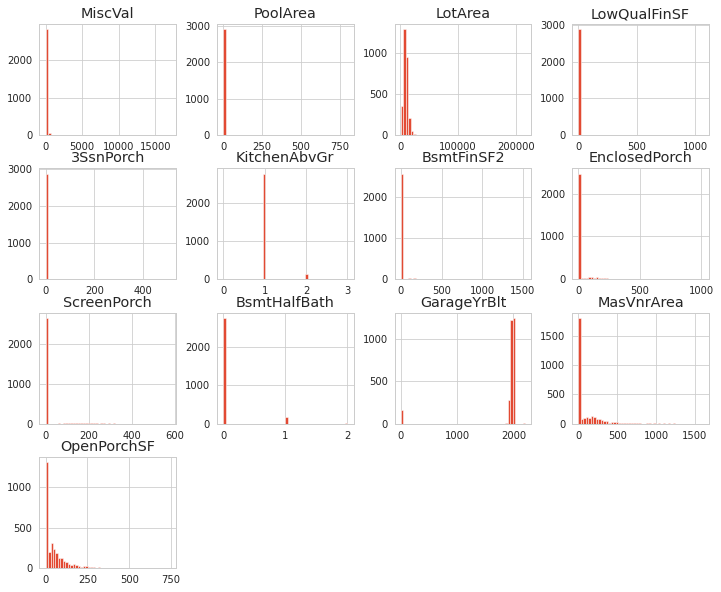

In [177]:
df[skewed_col].hist(bins=50, figsize=(12, 10));

범주형 데이터인 경우를 제외한 뒤 로그 변환을 시행 
- ``` nunique() , select_dtypes()```

In [178]:
log_features = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF',
                 'TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea',
                 'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr',
                 'TotRmsAbvGrd','Fireplaces','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF',
                 'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','YearRemodAdd']

num_cate_feature = df[log_features].nunique()
num_cate_feature = num_cate_feature[num_cate_feature < 20].index
num_cate_feature

Index(['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'PoolArea'],
      dtype='object')

In [179]:
num_log_feature = list(set(log_features) - set(num_cate_feature))
num_log_feature

['EnclosedPorch',
 '2ndFlrSF',
 'MiscVal',
 'ScreenPorch',
 'GrLivArea',
 'LotArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'MasVnrArea',
 'TotalBsmtSF',
 'WoodDeckSF',
 'OpenPorchSF',
 'GarageArea',
 '1stFlrSF',
 'LotFrontage',
 'LowQualFinSF',
 '3SsnPorch',
 'YearRemodAdd']

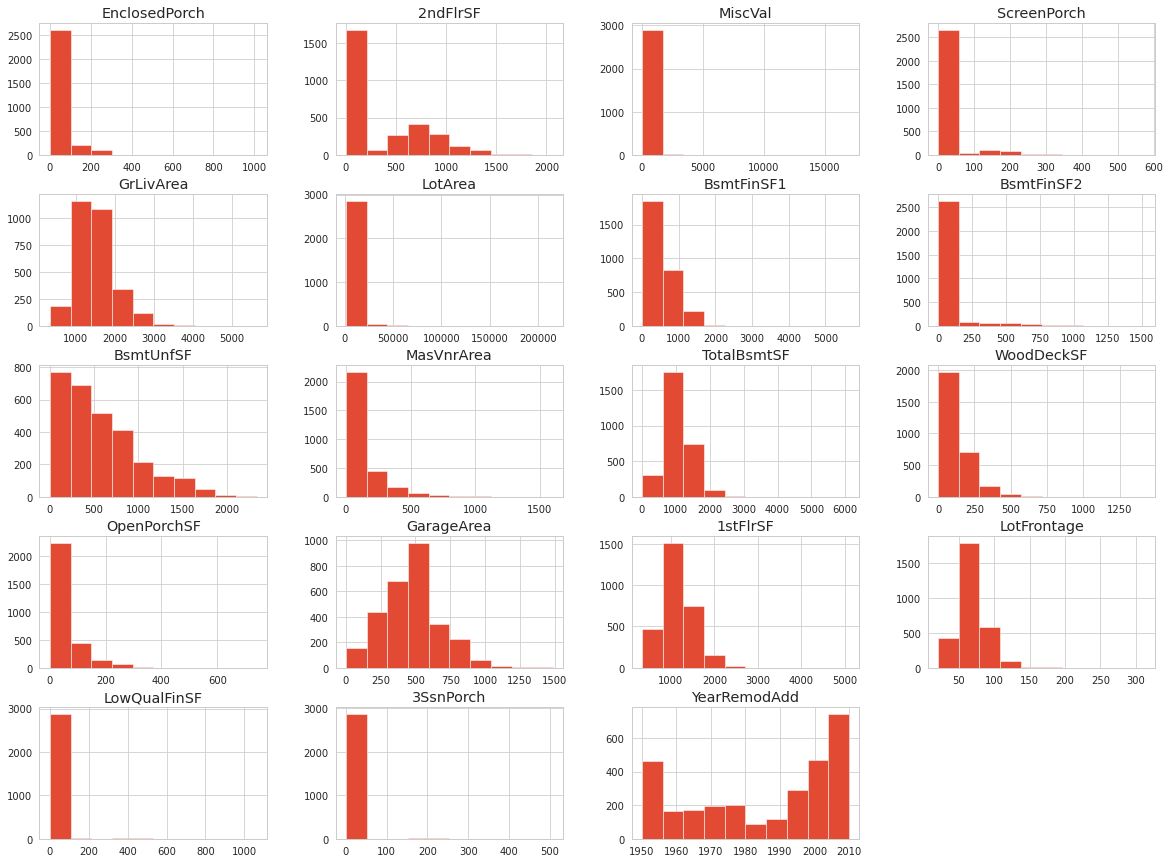

In [180]:
df[num_log_feature].hist(figsize=(20, 15));

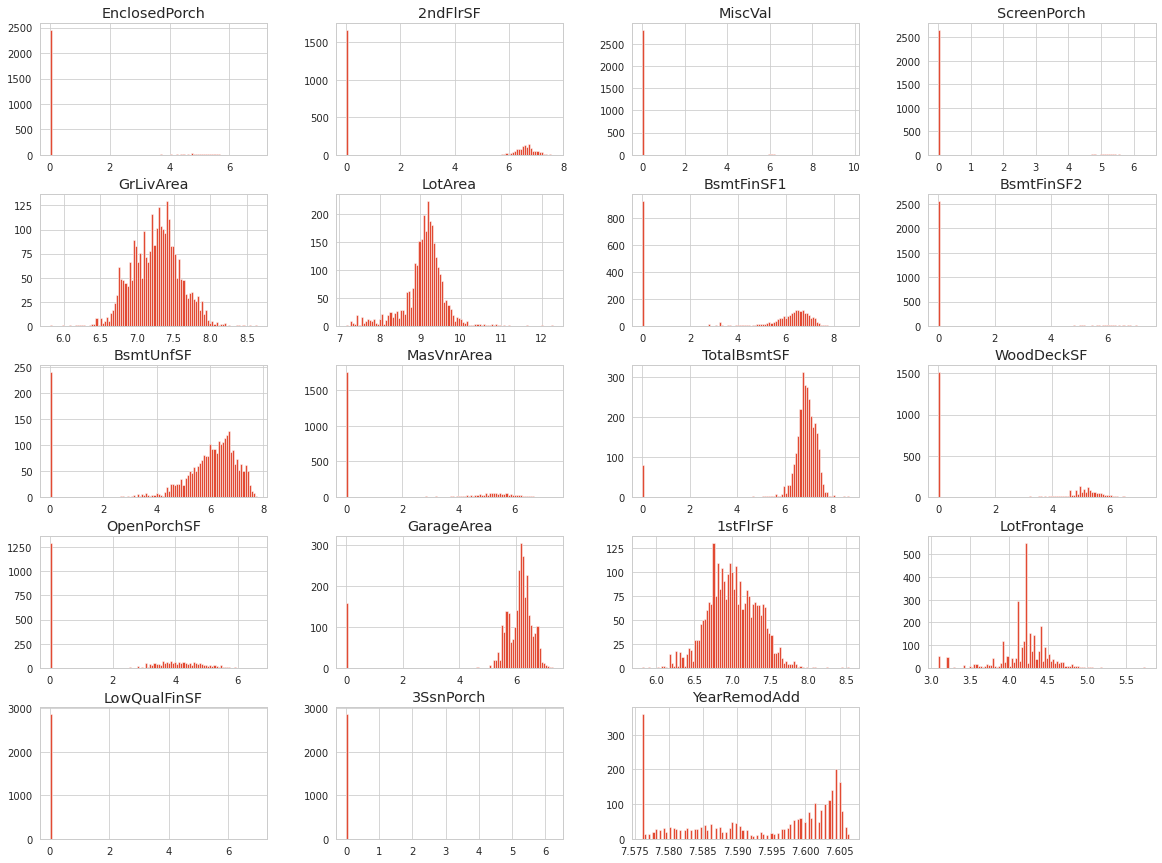

In [181]:
# log 변환
df[num_log_feature] = np.log1p(df[num_log_feature])
df[num_log_feature].hist(figsize=(20, 15), bins=100);

### 그 외 데이터 처리 
[필사한 노트북 코드 참고](https://www.kaggle.com/code/jesucristo/1-house-prices-solution-top-1/notebook)

#### Encoding


In [182]:
def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    
    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature+'_E'] = o
    
qual_encoded = []
for q in qualitative:  
    if q not in ['Alley', 'PoolQC', 'Fence', 'MiscFeature']:
        encode(train, q)
        qual_encoded.append(q+'_E')
print(qual_encoded)

['MSZoning_E', 'Street_E', 'LotShape_E', 'LandContour_E', 'Utilities_E', 'LotConfig_E', 'LandSlope_E', 'Neighborhood_E', 'Condition1_E', 'Condition2_E', 'BldgType_E', 'HouseStyle_E', 'RoofStyle_E', 'RoofMatl_E', 'Exterior1st_E', 'Exterior2nd_E', 'MasVnrType_E', 'ExterQual_E', 'ExterCond_E', 'Foundation_E', 'BsmtQual_E', 'BsmtCond_E', 'BsmtExposure_E', 'BsmtFinType1_E', 'BsmtFinType2_E', 'Heating_E', 'HeatingQC_E', 'CentralAir_E', 'Electrical_E', 'KitchenQual_E', 'Functional_E', 'FireplaceQu_E', 'GarageType_E', 'GarageFinish_E', 'GarageQual_E', 'GarageCond_E', 'PavedDrive_E', 'SaleType_E', 'SaleCondition_E']


#### Simple 클러스터링
차원 축소     
- t-SNE 알고리즘을 사용하여 고차원 공간의 데이터를 2차원에 정리
    - t-SNE는 데이터를 고차원에서 저차원으로 뿌려주는 방식으로 데이터를 시각화
    - 비선형 구조를 보존
- PCA
    - 고차원 공간에 있는 데이터를 차원 축소하여 새로운 변수 생성 
    -  원래 데이터의 분산을 최대한 보존하면서 데이터를 더욱 간결하게 나타낸다. 
군집화    
- K-Means
    - PCA로 차원 축소된 데이터를 K-Means 알고리즘을 사용하여 클러스터링
    - Means는 데이터를 여러 개의 클러스터로 나누어 비슷한 특성을 가진 데이터끼리 묶는다.

    

In [185]:
features = quantitative + qual_encoded

model = TSNE(n_components=2, random_state=0, perplexity=50)

X = train[features].fillna(0.).values
tsne = model.fit_transform(X)

In [186]:
std = StandardScaler()
s = std.fit_transform(X)

pca = PCA(n_components=30)
pca.fit(s)
pc = pca.transform(s)

PCA의 주성분(PC)이 설명하는 분산의 비율
- 차원 축소가 데이터의 정보를 얼마나 보존하고 있는지를 나타내며, 1에 가까울수록 좋다.

In [187]:
print(np.sum(pca.explained_variance_ratio_))

0.7884077304926331


t-SNE 알고리즘으로 차원을 축소한 데이터와      
K-Means 알고리즘으로 나눈 클러스터 정보를 사용하여     
각 데이터의 위치와 클러스터를 표현

In [188]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(pc)

KMeans(n_clusters=5)

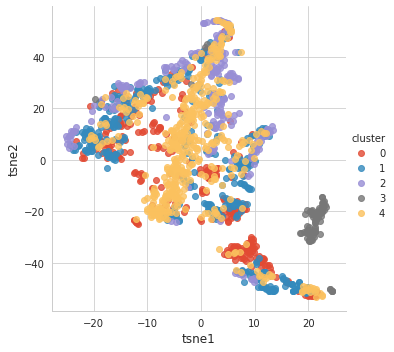

In [189]:
fr = pd.DataFrame({'tsne1': tsne[:,0], 'tsne2': tsne[:, 1], 'cluster': kmeans.labels_})
sns.lmplot(data=fr, x='tsne1', y='tsne2', hue='cluster', fit_reg=False)

## Modeling 

In [190]:
# select_dtypes
df_cate = df.select_dtypes(include="object")
df_cate.head(2)

,MSSubClass,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,NaN,Attchd,RFn,TA,TA,Y,2,2008,WD,Normal
1,20,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,8,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,5,2007,WD,Normal


범주형 feature 선택
- 범주형 변수 중에 결측치가 있는지 확인을 해보고 어떤 범주형 변수를 선택해서 모델에 사용할지 의사 결정
- 위에서 이미 결측치를 대부분 채워주었기 때문에 결측치가 거의 없지만 여전히 남아있는 결측치도 있다.
- 정렬을 하고 결측치가 있는 데이터를 제거하기 위해 슬라이싱을 사용
- 범주형 데이터는 원핫인코딩 작업을 하면서 결측치가 포함되지 않도록 처리되기 때문에 결측치를 남겨두어도 상관은 없다.


In [191]:
feature_cate = df_cate.isnull().mean().sort_values()[:-2].index
feature_cate

Index(['MSSubClass', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'KitchenQual',
       'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'MoSold', 'YrSold', 'SaleType', 'ExterCond', 'Foundation',
       'Condition1', 'MSZoning', 'Street', 'LotShape', 'LandContour',
       'LotConfig', 'LandSlope', 'Neighborhood', 'ExterQual', 'SaleCondition',
       'Condition2', 'BldgType', 'HouseStyle', 'OverallCond', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'Electrical', 'Utilities'],
      dtype='object')

In [192]:
train["SalePrice_log1p"] = np.log1p(train["SalePrice"])

label_name = "SalePrice_log1p"
label_name

'SalePrice_log1p'

Feature Name

In [193]:
df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodD

In [194]:
feature_names = []
feature_names.extend(num_log_feature)

feature_names.append("TotalSF")
feature_names.extend(feature_cate)

feature_names.remove("1stFlrSF")
feature_names.remove("2ndFlrSF")
feature_names.remove("BsmtFinSF1")
feature_names.remove("BsmtFinSF2")

#feature_names.remove("SalePrice")
feature_names

['EnclosedPorch',
 'MiscVal',
 'ScreenPorch',
 'GrLivArea',
 'LotArea',
 'BsmtUnfSF',
 'MasVnrArea',
 'TotalBsmtSF',
 'WoodDeckSF',
 'OpenPorchSF',
 'GarageArea',
 'LotFrontage',
 'LowQualFinSF',
 '3SsnPorch',
 'YearRemodAdd',
 'TotalSF',
 'MSSubClass',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'KitchenQual',
 'Functional',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'MoSold',
 'YrSold',
 'SaleType',
 'ExterCond',
 'Foundation',
 'Condition1',
 'MSZoning',
 'Street',
 'LotShape',
 'LandContour',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'ExterQual',
 'SaleCondition',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'OverallCond',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'Electrical',
 'Utilities']

### One-Hot Encoding

In [195]:
# 피처에 범주형 변수 개수 확인
df[feature_names].select_dtypes(include="O").shape

(2919, 41)

#### OneHotEncoder를 사용하지 않는 이유?
**pandas.get_dummies**
- 판다스(Pandas) 패키지에 있는 함수로, 범주형 변수를 처리하기 위해 사용
    - 입력 데이터의 모든 범주형 변수를 원-핫 인코딩하여 새로운 이진 변수로 변환한다.
- 이 때, 각 범주형 변수의 모든 값을 새로운 이진 변수로 만들어내기 때문에, 데이터의 차원이 증가한다.
- fit 메소드 없이도 바로 데이터를 변환할 수 있다.
-  get_dummies는 pandas에서 제공되는 함수로서 **데이터프레임 내 범주형 변수를 변환할 때 사용하는 것이 적합하다.**

**sklearn.preprocessing.OneHotEncoder**
- 사이킷런(Scikit-learn) 라이브러리에서 제공되는 클래스로, 범주형 변수를 처리하기 위해 사용한다.
- get_dummies와 마찬가지로 원-핫 인코딩을 수행하지만, 차원 축소를 위한 매개변수를 제공한다.  
- 이 매개변수를 사용하여, 원-핫 인코딩 된 결과를 희소 행렬(sparse matrix) 형태로 반환하거나, 또는 밀집 행렬(dense matrix) 형태로 반환할 수 있다.
- OneHotEncoder는 fit 메소드를 사용하여 원-핫 인코딩을 위한 매개변수를 학습하고, transform 메소드를 사용하여 데이터를 변환
- scikit-learn에서 제공하는 클래스로서 **변환된 데이터를 머신러닝 모델의 입력으로 사용할 때 적합하다.**

In [196]:
# train, test 가 concat 되어 있는 상태라면 get_dummies 를 사용하는 것이 가장 간단합니다.
df_ohe = pd.get_dummies(df[feature_names])
df_ohe.head(2)

,EnclosedPorch,MiscVal,ScreenPorch,GrLivArea,LotArea,BsmtUnfSF,MasVnrArea,TotalBsmtSF,WoodDeckSF,OpenPorchSF,GarageArea,LotFrontage,LowQualFinSF,3SsnPorch,YearRemodAdd,TotalSF,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_None,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_None,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_None,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_None,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,GarageFinish_Fin,GarageFinish_None,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_None,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_None,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,MoSold_1,MoSold_10,MoSold_11,MoSold_12,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,OverallCond_1,OverallCond_2,OverallCond_3,OverallCond_4,OverallCond_5,OverallCond_6,OverallCond_7,OverallCond_8,OverallCond_9,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1

get_dummies를 사용한다면 train 데이터와 test 데이터를 분리하지 않고도 바로 적용이 가능하다. 
- 왜냐하면 train 데이터의 범주형 변수를 분석하여 해당 변수가 가질 수 있는 모든 값의 집합을 파악하고, 이를 기반으로 데이터를 변환하기 때문.
- 모델 학습을 위해서는 train 데이터와 test 데이터를 분리하고, 각각에 대해 get_dummies를 적용하는 것이 좋다

In [197]:
# 원핫인코딩 후 기존 데이터와 개수를 비교합니다.
df[feature_names].shape, df_ohe.shape

((2919, 57), (2919, 297))

### Dataset 만들기

In [198]:
X_train = df_ohe.iloc[:1460]
X_test = df_ohe.iloc[1460:]

print(X_train.shape, X_test.shape)
print(X_train.isnull().sum().sum(), X_test.isnull().sum().sum())

(1460, 297) (1459, 297)
0 0


In [199]:
# label_name 확인
label_name

'SalePrice_log1p'

In [200]:
# y_train 만들기 - 학습에 사용할 정답값 예) 기출문제의 정답
y_train = train["SalePrice_log1p"]

print(y_train.shape)
y_train.head(2)

(1460,)


0    12.247699
1    12.109016
Name: SalePrice_log1p, dtype: float64

### 머신러닝 모델 만들기
- 기본 랜덤포레스트 회귀 모델 사용

In [201]:
model = RandomForestRegressor(random_state=42)
model

RandomForestRegressor(random_state=42)

In [202]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
kf

KFold(n_splits=5, random_state=42, shuffle=True)

In [203]:
X_train.shape, y_train.shape

((1460, 297), (1460,))

In [204]:
y_valid_predict = cross_val_predict(model, X_train, y_train, cv=kf, n_jobs=-1)
y_valid_predict

array([12.23748877, 11.9906342 , 12.29990609, ..., 12.54731488,
       11.83445682, 11.98353411])

### RMSE 계산 
- train score 출력

RMSE 계산 후 출력 

In [205]:
mse = np.square(y_train - y_valid_predict).mean()
rmse = np.sqrt(mse)
rmse

0.15348578996126624

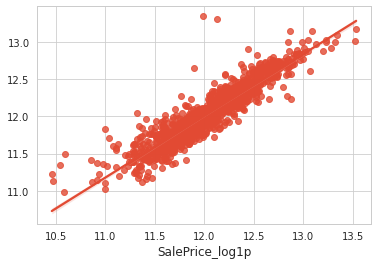

In [206]:
# regplot 으로 예측값에 대한 회귀선 그리기
sns.regplot(x=y_train, y=y_valid_predict)

In [207]:
from sklearn.metrics import r2_score

r2_score(y_train, y_valid_predict)

0.8522557320254941

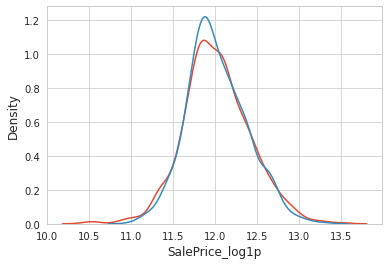

In [208]:
# kdeplot으로 실제값과 예측값 비교하기
sns.kdeplot(y_train)
sns.kdeplot(y_valid_predict)

## Prediction



In [209]:
# 학습한 모델로 test데이터 예측하기
y_predict = model.fit(X_train, y_train).predict(X_test)
y_predict

array([11.72191811, 12.03490083, 12.15089065, ..., 11.95091283,
       11.62243726, 12.22831223])

### Feature Importances

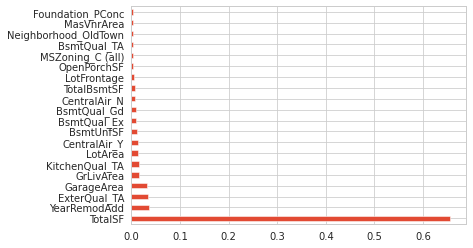

In [210]:
fi = pd.Series(model.feature_importances_)
fi.index = model.feature_names_in_
fi.nlargest(20).plot.barh()

In [211]:
# 제출 파일 양식을 불러옵니다.
submit = pd.read_csv(f"{base_root}/dataset/sample_submission.csv")
submit.head(2)

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989


In [212]:
# 내부 평가 - Log 취한 값 
# 실제 제출 시 exp 적용 후 제출
submit["SalePrice"] = np.expm1(y_predict)

In [213]:
file_name = f"{base_root}/dataset/submission_{rmse:.5f}.csv"
file_name

'/content/drive/MyDrive/캐굴캐굴/3주차/dataset/submission_0.153.csv'

In [214]:
# csv 파일로 저장합니다.
submit.to_csv(file_name, index=False)

In [215]:
# 제대로 저장되었는지 확인합니다.
pd.read_csv(file_name)

,Id,SalePrice
0,1461,123242.593596
1,1462,168534.355524
2,1463,189261.580996
3,1464,183038.513363
4,1465,192687.586734
...,...,...
1454,2915,85702.385570
1455,2916,91132.589113
1456,2917,154957.532461
1457,2918,111572.322667


리더보드 스코어 = 0.15044

2129등